In [ ]:
import torch
import torchaudio
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name·(0) if torch.cuda.is_available() else "No GPU available")

data = np.load("hvcm/RFQ.npy", allow_pickle=True)
label = np.load("hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)


cuda
NVIDIA A100-PCIE-40GB
(872, 4500, 14) (872,)


# Processing: Mel Spec > Resizing > Feature Extraction

In [3]:
# Resize and convert to 3-channel image
def resize_spectrogram(spectrogram):
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-6)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

# Process dataset
def process_dataset(data):
    num_samples, _, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=2500000, n_mels=128).to(device)
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()

    for i in range(num_samples):
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            img = resize_spectrogram(mel)
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    return features

# AE Class

In [51]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16), 
            nn.ReLU(),
            nn.Linear(16, 32), 
            nn.ReLU(),
            nn.Linear(32, 64), 
            nn.ReLU(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data):
    model.eval()
    x = torch.tensor(data.reshape(-1, 4096), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    loss = []
    criterion = torch.nn.MSELoss(reduction='none')
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            batch_errors = criterion(outputs, inputs).mean(dim=1)
            loss.extend(batch_errors.cpu().numpy())
    return np.array(loss)

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    # Step 1: Flatten the test data
    n_samples, n_segments, n_features = X_test.shape
    X_test_flat = X_test.reshape(-1, n_features)

    # Step 2: Compute reconstruction errors per segment
    segment_errors = compute_reconstruction_loss(model, X_test_flat)

    # Step 3: Aggregate errors per sample (mean over segments)
    sample_errors = segment_errors.reshape(n_samples, n_segments).mean(axis=1)

    # Step 4: Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(sample_errors.min(), sample_errors.max(), 100):
        preds = (sample_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Step 5: Predict using best threshold
    test_preds = (sample_errors > best_threshold).astype(int)

    # Step 6: Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))



# Preprocessing

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features = process_dataset(scaled_data)
print("Features shape:", features.shape)

/home/maddie/SmartIoT-2025/.venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Features shape: (872, 14, 4096)


# Cross Validation with StandardScaler

Fold 1
Epoch 1/15, Loss: 0.732855
Epoch 2/15, Loss: 0.622377
Epoch 3/15, Loss: 0.622161
Epoch 4/15, Loss: 0.622152
Epoch 5/15, Loss: 0.622160
Epoch 6/15, Loss: 0.622120
Epoch 7/15, Loss: 0.622130
Epoch 8/15, Loss: 0.622139
Epoch 9/15, Loss: 0.622132
Epoch 10/15, Loss: 0.622078
Epoch 11/15, Loss: 0.622107
Epoch 12/15, Loss: 0.622097
Epoch 13/15, Loss: 0.622094
Epoch 14/15, Loss: 0.622096
Epoch 15/15, Loss: 0.622123
Best threshold: 0.6822258709657072, Best F1 Score: 0.41750000000000004


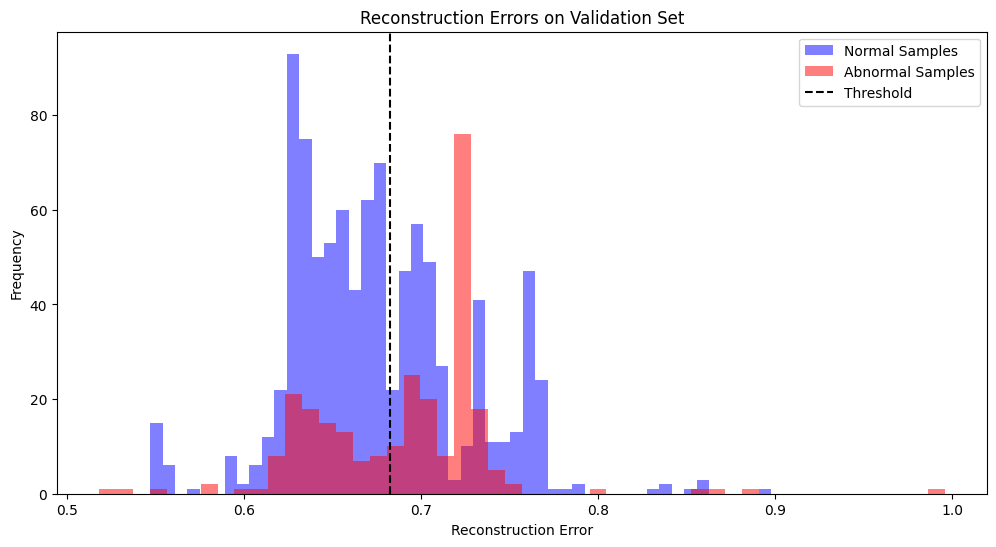

Best Threshold = 0.685764, Best F1 Score = 0.4348
Evaluation on Test Set:
Accuracy = 0.8522727272727273
Precision = 1.0
Recall = 0.2777777777777778
F1 Score = 0.4347826086956522
Confusion Matrix:
 [[70  0]
 [13  5]]
Fold 2
Epoch 1/15, Loss: 0.731570
Epoch 2/15, Loss: 0.622179
Epoch 3/15, Loss: 0.622088
Epoch 4/15, Loss: 0.622034
Epoch 5/15, Loss: 0.622092
Epoch 6/15, Loss: 0.622053
Epoch 7/15, Loss: 0.622052
Epoch 8/15, Loss: 0.622071
Epoch 9/15, Loss: 0.622033
Epoch 10/15, Loss: 0.622000
Epoch 11/15, Loss: 0.622030
Epoch 12/15, Loss: 0.622025
Epoch 13/15, Loss: 0.622030
Epoch 14/15, Loss: 0.621959
Epoch 15/15, Loss: 0.622035
Best threshold: 0.7085593372884422, Best F1 Score: 0.42454394693200664


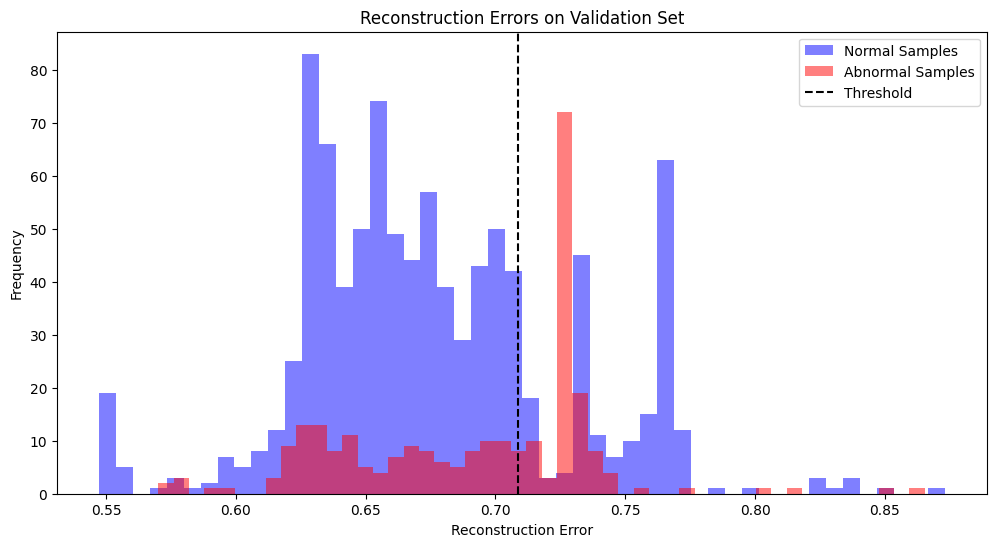

Best Threshold = 0.687345, Best F1 Score = 0.5600
Evaluation on Test Set:
Accuracy = 0.875
Precision = 1.0
Recall = 0.3888888888888889
F1 Score = 0.56
Confusion Matrix:
 [[70  0]
 [11  7]]
Fold 3
Epoch 1/15, Loss: 0.715510
Epoch 2/15, Loss: 0.622258
Epoch 3/15, Loss: 0.622194
Epoch 4/15, Loss: 0.622187
Epoch 5/15, Loss: 0.622157
Epoch 6/15, Loss: 0.622135
Epoch 7/15, Loss: 0.622073
Epoch 8/15, Loss: 0.622122
Epoch 9/15, Loss: 0.622060
Epoch 10/15, Loss: 0.622138
Epoch 11/15, Loss: 0.622089
Epoch 12/15, Loss: 0.622089
Epoch 13/15, Loss: 0.622058
Epoch 14/15, Loss: 0.622082
Epoch 15/15, Loss: 0.622004
Best threshold: 0.6901432697219078, Best F1 Score: 0.41767068273092367


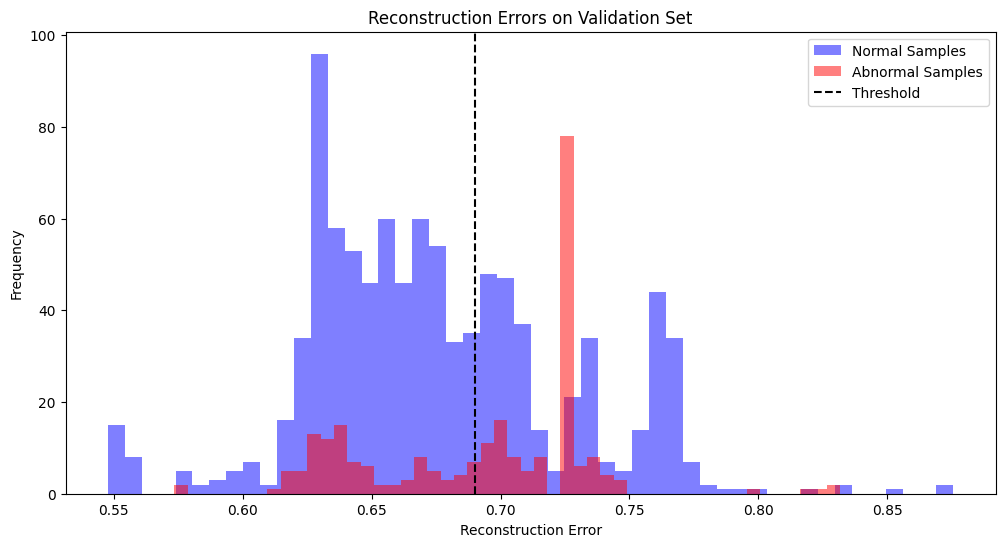

Best Threshold = 0.684217, Best F1 Score = 0.4000
Evaluation on Test Set:
Accuracy = 0.8275862068965517
Precision = 0.7142857142857143
Recall = 0.2777777777777778
F1 Score = 0.4
Confusion Matrix:
 [[67  2]
 [13  5]]
Fold 4
Epoch 1/15, Loss: 0.735192
Epoch 2/15, Loss: 0.622383
Epoch 3/15, Loss: 0.622240
Epoch 4/15, Loss: 0.622134
Epoch 5/15, Loss: 0.622104
Epoch 6/15, Loss: 0.622133
Epoch 7/15, Loss: 0.622030
Epoch 8/15, Loss: 0.622005
Epoch 9/15, Loss: 0.622018
Epoch 10/15, Loss: 0.622063
Epoch 11/15, Loss: 0.621976
Epoch 12/15, Loss: 0.622115
Epoch 13/15, Loss: 0.622046
Epoch 14/15, Loss: 0.622032
Epoch 15/15, Loss: 0.622037
Best threshold: 0.679368485103954, Best F1 Score: 0.3585147247119078


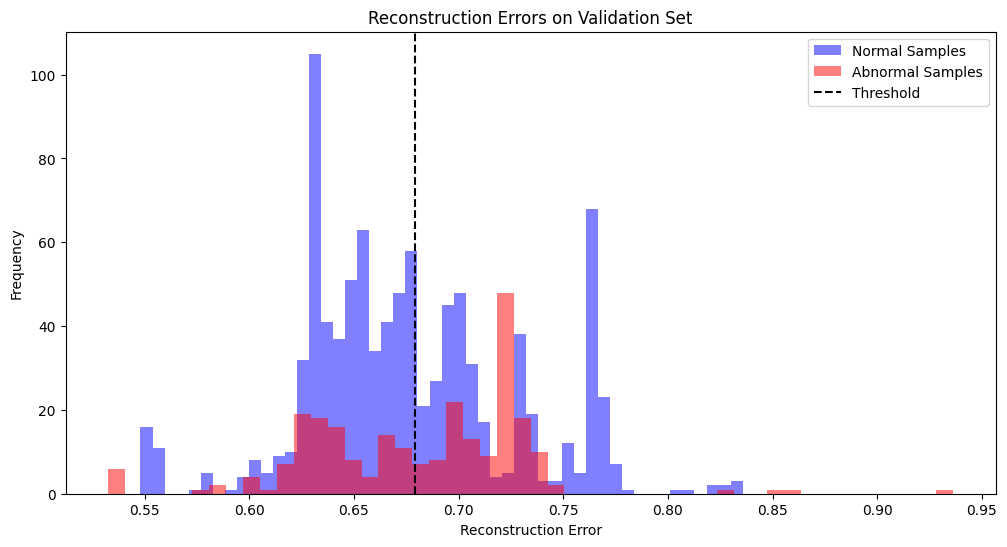

Best Threshold = 0.685399, Best F1 Score = 0.5000
Evaluation on Test Set:
Accuracy = 0.8620689655172413
Precision = 1.0
Recall = 0.3333333333333333
F1 Score = 0.5
Confusion Matrix:
 [[69  0]
 [12  6]]
Fold 5
Epoch 1/15, Loss: 0.728507
Epoch 2/15, Loss: 0.622241
Epoch 3/15, Loss: 0.622218
Epoch 4/15, Loss: 0.622158
Epoch 5/15, Loss: 0.622228
Epoch 6/15, Loss: 0.622192
Epoch 7/15, Loss: 0.622187
Epoch 8/15, Loss: 0.622135
Epoch 9/15, Loss: 0.622183
Epoch 10/15, Loss: 0.622116
Epoch 11/15, Loss: 0.622188
Epoch 12/15, Loss: 0.622107
Epoch 13/15, Loss: 0.622139
Epoch 14/15, Loss: 0.622076
Epoch 15/15, Loss: 0.622110
Best threshold: 0.7111074990696378, Best F1 Score: 0.5167785234899329


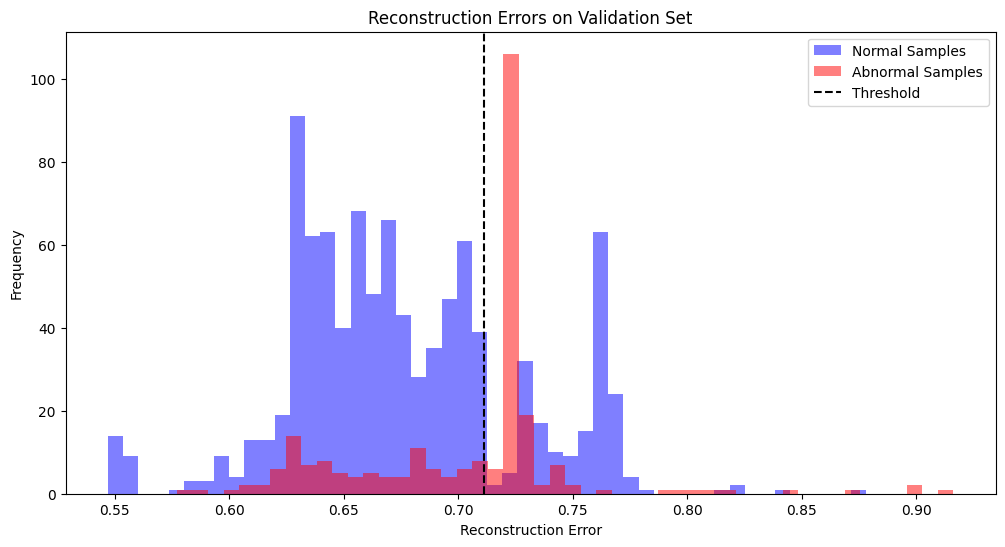

Best Threshold = 0.683040, Best F1 Score = 0.6667
Evaluation on Test Set:
Accuracy = 0.896551724137931
Precision = 1.0
Recall = 0.5
F1 Score = 0.6666666666666666
Confusion Matrix:
 [[69  0]
 [ 9  9]]


In [56]:

for fold, (train_idx, val_idx) in enumerate(skf.split(features, label)):
    
    print(f"Fold {fold + 1}")
    
    # Get full fold data
    fold_data, fold_labels = features[train_idx], label[train_idx]
    val_data, val_labels = features[val_idx], label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=42)

    # Train autoencoder on the training fold
    model = train_autoencoder(X_train[y_train == 0], epochs=15, batch_size=32)

    # Evaluate on validation fold
    val_errors_normal = compute_reconstruction_loss(model, X_val[y_val == 0])
    val_errors_abnormal = compute_reconstruction_loss(model, X_val[y_val == 1])
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    

    val_errors_test = compute_reconstruction_loss(model, X_test)
    

    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)



# Observation:

Accuracy = 0.896551724137931

Precision = 1.0

Recall = 0.5

F1 Score = 0.6666666666666666

Confusion Matrix:

 [[69  0]

 [ 9  9]]
